## Chapter 11: Principles of Feature Learning

# 11.3 Universal Approximation of Real Data

In the previous Section we saw how a nonlinear model built from units of a single universal approximator can be made to tightly approximate any *perfect dataset* if we increase its capacity sufficiently and tune the model's parameters properly by minimizing an appropriate cost function. In this Section we will investigate how universal approximation carries over to the case of *real data*, i.e., data that is finite in size and potentially noisy. We will then learn about a new measurement tool, called *validation error*, that will allow us to effectively employ universal approximators with real data. 

In [2]:
# This code cell will not be shown in the HTML version of this notebook
# append path for local library, data, and image import
import sys
sys.path.append('./chapter_11_library') 
sys.path.append('./chapter_11_images') 
sys.path.append('./chapter_11_datasets') 

# backend file
import section_11_2_helpers

# data path
data_path_1 = 'chapter_11_datasets/noisy_sin_sample.csv'
data_path_2 = 'chapter_11_datasets/new_circle_data.csv'

# image paths
image_path_1 = "chapter_11_images/Figure_11_18.png"
image_path_2 = "chapter_11_images/Figure_11_21.png"
image_path_3 = "chapter_11_images/Figure_11_24.png"
image_path_4 = "chapter_11_images/Figure_11_25.png"
image_path_5 = "chapter_11_images/Figure_11_26.png"
image_path_6 = "chapter_11_images/Figure_11_27.png"

# video paths
video_path_1 = 'chapter_11_videos/animation_2.mp4'
video_path_2 = 'chapter_11_videos/animation_3.mp4'
video_path_3 = 'chapter_11_videos/animation_4.mp4'

# standard imports
import matplotlib.pyplot as plt
from matplotlib import gridspec
import IPython, copy

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## Prototypical examples

Here we explore the use of universal approximators in representing real data using two simple examples: a regression and two-class classification dataset. The problems we encounter with these two simple examples mirror those we face in general when employing universal approximator-based models to real data, regardless of problem type.

#### <span style="color:#a50e3e;">Example 11.7:</span>  Universal approximation of real regression data

In this example we illustrate the use of universal approximators on a real regression dataset that is based on the near-perfect sinusoidal data presented in Example 11.5. To simulate a real version of this dataset we randomly selected $P = 21$ of its points and added a small amount of random noise to the output (i.e., $y$ component) of each point, as illustrated in [Figure 11.18](#figure-11-18).

---

In [3]:
IPython.display.HTML('''<img src="''' + image_path_1 + '''" width="90%" height="auto" alt=""/>''')

<a id='figure-11-18'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.18 </strong> <em> 
(left panel) The original *near-perfect* sinusoidal dataset from Example 11.5. (right panel) A *real* regression dataset formed by adding random noise to the output of a small subset of the near-perfect dataset's points. See text for further details.
</em>
</figcaption>
</figure>

---

In the animation below we illustrate the fully tuned nonlinear fit of a model employing $1$ through $20$ polynomial units (left panel), single-layer $\text{tanh}$ neural network (middle panel), and stump units (right panel) to this data. Notice how, with each of the universal approximators, all three models *underfit* the data when using only $B = 1$ unit in each case. This underfitting of the data is a direct consequence of using low capacity models which produce fits that are not *complex* enough for the underlying data they are aiming to approximate. Also notice how each model improves as we increase $B$, but only up to a certain point after which each *tuned* model becomes far too complex and starts to look rather wild, and very much unlike the sinusoidal phenomenon that originally generated the data. This is especially visible in the polynomial and neural network cases, where by the time we reach $B = 20$ units both models are extremely oscillatory and far too complex. Such *overfitting* models while representing the current data well, will clearly make for poor predictors of future data generated by the same process. 

---

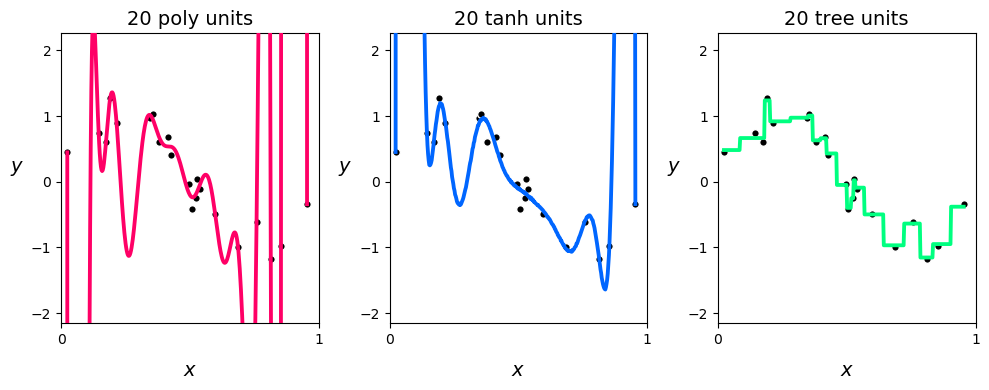

In [16]:
## This code cell will not be shown in the HTML version of this notebook
# produce visual comparison of different universal approximator fits
demo = section_11_2_helpers.Visualizer()
demo.load_data(data_path_1)
demo.brows_fits(video_path_1,num_elements = [v for v in range(1,21,1)],scatter = 'on',fps=2)

In [17]:
## This code cell will not be shown in the HTML version of this notebook
# load in video and display
from IPython.display import HTML
HTML("""
<video width="700" height="400" controls loop>
  <source src='""" + video_path_1 + """' type="video/mp4">
  </video>
""")

---

Below we animate several of the polynomial-based models shown above, along with the corresponding Least Squares cost value each attains, i.e., the model's *training error*. In adding more polynomial units we turn up the capacity of our model and, optimizing each model to completion, the resulting tuned models achieve lower and lower training error. Doing this clearly *decreases* the cost function value over the training set (just as with perfect or near-perfect data). However the resulting fit provided by each fully tuned model (after a certain point) becomes far too complex and starts to get *worse* in terms of how it represents the general regression phenomenon. As a measurement tool the training error only tells us how well a tuned model fits the *training data*, but fails to tell us when our tuned model becomes too complex.

In [ ]:
## This code cell will not be shown in the HTML version of this notebook
# produce visual comparison of different universal approximator fits
demo2 = section_11_2_helpers.SingleVisualizer()
demo2.load_data(data_path_1)
demo2.browse_single_fit(savepath=video_path_2,basis='poly',num_units = [v for v in range(1,21,1)],fps=1)

In [21]:

# load in video and display
from IPython.display import HTML
HTML("""
<video width="800" height="400" controls loop>
  <source src='""" + video_path_2 + """' type="video/mp4">
  </video>
""")

---

#### <span style="color:#a50e3e;">Example 11.8:</span>  Universal approximation of real classification data

In this example we illustrate the application of universal approximator-based models on a real two-class classification dataset that is based on the near-perfect dataset presented in Example 11.6. Here we simulated a realistic version of this data by randomly selecting $P = 99$ of its points, and adding a small amount of classification noise by flipping the labels of $5$ of those points, as shown in Figure 11.18.

---

In [5]:
IPython.display.HTML('''<img src="''' + image_path_2 + '''" width="90%" height="auto" alt=""/>''')

<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.18 </strong> <em> 
(left panel) The original near-perfect classification dataset from Example 11.6, with the true circular boundary used to generate the data shown in dashed black (this is the boundary we hope to recover using classification). (right panel) A real dataset formed from a noisy subset of these points. See text for further details. 
</em>
</figcaption>
</figure>

---

In Figure 11.18 we show the nonlinear decision boundaries provided by fully tuned models employing $B = 1$ through $B = 20$ polynomial units (top row), $B = 1$ through $B = 9$ single-layer $\text{tanh}$ neural network units (middle row), and $B = 1$ through $B = 17$ stump units (bottom row), respectively. At the start all three tuned models are not complex enough and thus *underfit* the data, providing a classification that in all instances simply classifies the entire space as belonging to the blue class (label values $y = -1$). After that and up to a certain point the decision boundary provided by each model improves as more units are added, with $B = 5$ polynomial units, $B = 3$ $\text{tanh}$ units, and $B = 5$ stump units providing reasonable approximations to the desired circular decision boundary. However soon after we reach these numbers of units each tuned model becomes too complex and *overfits* the training data, with the decision boundary of each drifting away from the circular boundary centered at the origin that would properly predict the labels of future data generated by the same underlying phenomenon.  As with regression in Example 11.7, both underfitting and overfitting problems occur in the classification case as well, regardless of the sort of universal approximator used.

In [ ]:
# This code cell will not be shown in the HTML version of this notebook
# load in data
demo3 = section_11_2_helpers.ClassificationVisualizer(data_path_2)

# run approximators
demo3.runs1 = demo3.run_poly(5)
demo3.runs2 = demo3.run_net(12)
demo3.runs3 = demo3.run_trees(20)

# animate
frames = 5
demo3.animate_comparisons(savepath = video_path_3,frames=frames,fps=1)

In [31]:
# This code cell will not be shown in the HTML version of this notebook
# load in video and display
from IPython.display import HTML
HTML("""
<video width="800" height="400" controls loop>
  <source src='""" + video_path_3 + """' type="video/mp4">
  </video>
""")

In the animation below we plot several of the neural network-based models shown above, along with the corresponding two-class softmax cost value each attains. As expected, increasing model capacity by adding more $\text{tanh}$ units always (upon tuning the parameters of each model by complete minimization) *decreases* the cost function value (just as with perfect or near-perfect data). However the resulting classification, after a certain point, actually gets *worse* in terms of how it (the learned decision boundary) represents the general classification phenomenon.

In [5]:
# This code cell will not be shown in the HTML version of this notebook
import copy

# the mid-point between each set of consecutive inputs along each input dimension
data = np.loadtxt(data_path_2,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:]

### boosting ###
num_units = 6
run1 = []
for j in range(num_units):
    print ('fitting ' + str(j + 1) + ' units')
    
    # import the v1 library
    mylib1 = nonlib.intro_general_library.superlearn_setup.Setup(x,y)

    # choose features
    mylib1.choose_features(name = 'multilayer_perceptron',layer_sizes = [2,j+1,1],activation = 'tanh')

    # choose normalizer
    mylib1.choose_normalizer(name = 'standard')

    # pick training set
    mylib1.make_train_valid_split(train_portion=1)
            
    # choose cost
    mylib1.choose_cost(name = 'softmax')

    # fit an optimization
    mylib1.fit(max_its = 6000,alpha_choice = 10**(0),optimizer = 'gradient_descent')

    # add model to list
    run1.append(copy.deepcopy(mylib1))
    
# animate the business
frames = num_units
demo = nonlib.main_classification_animators.Visualizer(csvname)
savepath = 'videos/animation_5.mp4'
demo.animate_classifications(savepath,run1,frames,fps=0.5)

# load in video and display
from IPython.display import HTML
HTML("""
<video width="800" height="400" controls loop>
  <source src="videos/animation_5.mp4" type="video/mp4">
  </video>
""")

---

In summary, in the Examples here we have seen that, unlike the case with perfect data, when employing universal approximator-based models with real data we must be careful with how we set the capacity of our model, as well as how well we tune its parameters via optimization of an associated cost. These two simple examples also show how training error fails as a reliable tool to measure how well a tuned model represents the phenomenon underlying a real dataset. Both of these issues arise in general, and are discussed in greater detail next.

## The capacity and optimization dials, revisited

The prototypical examples described above illustrate how with real data we cannot (as we can in the case of perfect data) simply set our capacity and optimization dials (introduced in Section 11.2.4) all the way to the right, as this leads to overly complex models that fail to represent the underlying data-generating phenomenon well.  Notice, we only control the *complexity* of a tuned model (or, roughly speaking, how "wiggly" a tuned model fit is) *indirectly* by how we set both our capacity and optimization dials, and it is not obvious *a priori* how we should set them simultaneously in order to achieve the right amount of model complexity for a given dataset.  However, we can make this dial-tuning problem somewhat easier by fixing one of the two dials and adjusting only the other.  Setting one dial all the way to the right imbues the other dial with the sole control over the complexity of a tuned model (and turns it into - roughly speaking - the *complexity dial* described in Section 11.1).  That is, fixing one of the two dials all the way to the right, as we turn the unfixed dial from left to right we increase the complexity of our final tuned model.  This is a general principle when applying universal approximator-based models to real data that does not present itself in the case of perfect data.

To gain a stronger intuition for this principle, suppose first that we set our optimization dial all the way to the right (meaning that regardless of the dataset and model we use, we always tune its parameters by minimizing the corresponding cost function to completion). Then with perfect data, as illustrated in the top row of [Figure 11.24](#figure-11-24),  as we turn our capacity dial from left to right (e.g., by adding more units) the resulting tuned model provides a better and better representation of a the perfect dataset.

However with real data, as illustrated in the bottom row of [Figure 11.24](#figure-11-24), starting with our capacity dial all the way to the left, the resulting tuned model is not complex enough for the phenomenon underlying our data.  We say that such a tuned model *underfits*, as it does not even fit the given data well.  Notice that while the simple visual depiction here illustrates an underfitting model as a linear ('un-wiggly') function - which is quite common in practice - it is possible for an underfitting model to be quite 'wiggly'.  Regardless of the 'shape' a tuned model takes we say that it underfits if it poorly represents the training data - i.e., if it has high training error.

Turning the capacity dial from left to right *increases* the complexity of each tuned model, providing a better and better representation of the data and the phenomenon underlying it. However there comes a point, as we continue turning the dial from left to right, where the corresponding tuned model becomes *too complex* to represent the phenomenon underlying the data. Indeed past this point, where the complexity of each tuned model is wildly inappropriate for the phenomenon at play, we say that *overfitting* begins. This language is used because while such highly complex models fit the given data extremely well, they do so at the cost of not representing the underlying phenomenon well. As we continue to turn our capacity dial to the right the resulting tuned models will become increasingly complex and increasingly less representative of the true underlying phenomenon.  

---

In [6]:
IPython.display.HTML('''<img src="''' + image_path_3 + '''" width="90%" height="auto" alt=""/>''')

<a id='figure-11-24'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.24 </strong> <em> 
(top row) With *perfect data* if we set our optimization dial to all the way to the right, as we increase the capacity of our model by turning the capacity dial from left to right (starting all the way to the left) the corresponding representation gets better and better. (bottom row) With *real data* a similar effect occurs, however here as we turn the capacity further to the right each tuned model will tend to become more and more complex, eventually overfitting the given data. See text for further details.
</em>
</figcaption>
</figure>

---

Now suppose instead that we turn our capacity dial all the way to the right, using a very high capacity model, and set its parameters by turning our optimization dial ever so slowly from left to right. In the case of perfect data, as illustrated in the top row of [Figure 11.25](#figure-11-25), this approach produces tuned models that increasingly represents the data well. With real data on the other hand, as illustrated in the bottom row of [Figure 11.25](#figure-11-25), starting with our optimization dial set all the way to the left will tend to produce low complexity *underfitting* tuned models. As we turn our optimization dial from left to right, taking steps of a particular local optimization scheme, our corresponding model will tend to increase in complexity, improving its representation of the given data. This improvement continues only up to a point where our corresponding tuned model becomes too complex for the phenomenon underlying the data, and hence *overfitting* begins. After this point the tuned models arising from turning the optimization dial further to the right are far too complex to adequately represent the phenomenon underlying a dataset.  

---

In [7]:
IPython.display.HTML('''<img src="''' + image_path_4 + '''" width="90%" height="auto" alt=""/>''')

<a id='figure-11-25'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.25 </strong> <em> 
(top row) With perfect data if we set our capacity dial all the way to the right, as we increase the amount we optimize our model by turning the optimization dial from left to right (starting all the way on the left where for simplicity we assume all model parameters are  initialized at zero) the corresponding representation gets better and better. (bottom row) With real data a similar effect occurs, but only up to a certain point where overfitting begins. See text for further details.
</em>
</figcaption>
</figure>

---

## Motivating a new measurement tool

How we set our capacity and optimization dials in order to achieve a final tuned model that has *just the right amount of complexity* for a given dataset is the main challenge we face when employing universal approximator-based models with real data. In Examples 11.7 and 11.8 we saw how training error fails to indicate when a tuned model has sufficient *complexity* for the tasks of regression and two-class classification respectively, a fact more generally true about all nonlinear machine learning problems as well. If we cannot rely on training error to help decide on the proper amount of complexity required to address real nonlinear machine learning tasks, what sort of measurement tool should we use instead? Closely examining [Figure 11.26](#figure-11-26) reveals the answer! 

In the top row of this Figure we show three instances of models presented for the toy regression dataset in Example 11.6: a fully tuned low complexity (and underfitting) linear model in the left panel, a high complexity (and overfitting) degree $20$ polynomial model in the middle panel, and a degree $3$ polynomial model in the right panel that fits the data and the underlying phenomenon generating it "just right." What do both the underfitting and overfitting patterns have in common, that the "just right" model does not?

Scanning the left two panels of the Figure we can see that a common 
problem with both the underfitting and overfitting models is that, while they differ in how well they represent data *we already have*, they will both fail to adequately represent *new data* generated via the same process by which the current data was made. In other words, we would not trust either model to predict the output of a newly arrived input point. The "just right" fully tuned model does not suffer from the same problem as it closely approximates the sort of wavy sinusoidal pattern underlying the data, and as a result would work well as a predictor for future data points.

The same story tells itself in the bottom row of the Figure with our two-class classification dataset used previously in Example 11.7. Here we show a fully tuned low complexity (and underfitting) linear model in the left panel, a high complexity (and overfitting) degree $20$ polynomial model in the middle panel, and "just right" degree $2$ polynomial model in the right panel. As with the regression case, the underfitting and overfitting models both fail to adequately
represent the underlying phenomenon generating our current data and, as a result, will fail to adequately predict the label values of *new data* generated via the same process by which the current data was made. 

In summary, with both the simple regression and classification examples discussed here we can roughly qualify poorly performing models as those that will not allow us to make accurate predictions of data we will receive in the future. But how do we quantify something we will receive in the future? We address this next.

---

In [8]:
IPython.display.HTML('''<img src="''' + image_path_5 + '''" width="90%" height="auto" alt=""/>''')

<a id='figure-11-26'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.26 </strong> <em> 
(top row) Three models for the regression dataset from Example 11.6: an underfitting model (top left panel), an overfitting model (top middle panel), and a "just right" one (top right panel). (bottom row) Three models for the two-class classification dataset from Example 11.7: an underfitting model that simply classifies everything as part of the blue class (bottom left panel), an overfitting model (bottom middle panel), and a "just right" fit (bottom right panel). See text for further details. 
</em>
</figcaption>
</figure>

---

## The validation error


We now have an informal diagnosis for the problematic performance of underfitting/overfitting models: such models do not accurately represent new data we might receive in the future. But how can we make use of this diagnosis? We of course do not have access to any new data we will receive in the future. To make this notion useful we need to translate it into a quantity we can always measure, regardless of the dataset/problem we are tackling or the kind of model we employ.

The universal way to do this is, in short, to *fake it*: we simply remove a random portion of our data and treat it as "new data we might receive in the future," as illustrated abstractly in [Figure 11.27](#figure-11-27). In other words, we cut out a random chunk of the dataset we have, train our selection of models on only the portion of data that remains, and *validate* the performance of each model on this randomly removed chunk of "new" data. The random portion of the data we remove to validate our model(s) is commonly called the *validation data*  (or validation set), and the remaining portion we use to train models is likewise referred to as the *training data* (or training set). The model providing the lowest error on the validation data, i.e., the *lowest validation error*, is then deemed the best choice from a selection of trained models. As we will see validation error (unlike training error) is in fact a proper measurement tool for determining the quality of a model against the underlying data generating phenomenon we want to capture.

---

In [9]:
IPython.display.HTML('''<img src="''' + image_path_6 + '''" width="90%" height="auto" alt=""/>''')

<a id='figure-11-27'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.27 </strong> <em> 
Splitting the data into training and validation sets. The
original data shown in the left panel as the entire round mass is
split randomly in the right panel into two non-overlapping sets. The smaller piece, typically or \(\frac{1}{10}\) to \(\frac{1}{3}\) of the original data, is then taken as the validation set with the remaining taken as the training set.
</em>
</figcaption>
</figure>

---

There is no precise rule for what portion of a given dataset should be saved for validation. In practice, typically between $\frac{1}{10}$ to $\frac{1}{3}$ of the data is assigned to the validation set. Generally speaking, the larger and/or more representative (of the true phenomenon from which the data is sampled) a dataset is the larger the portion of the original data may be assigned to the validation set (e.g., $\frac{1}{3}$). The intuition for doing this is that if the data is plentiful/representative enough, the training set still accurately represents the underlying phenomenon even after removal of a relatively large set of validation data. Conversely, in general with smaller or less representative (i.e., more noisy or poorly distributed) datasets we usually take a smaller portion for validation (e.g., $\frac{1}{10}$) since the relatively larger training set needs to retain what little information of the underlying phenomenon was captured by the original data, and little data can be spared for validation.